# CUTOUTS

In [22]:
__author__ = 'Steve Pothier <steve.pothier@noirlab.edu>'
__version__ = '20231027' # yyyymmdd; 
__keywords__ = ['HowTo', 'astronomy', 'tutorial', 'client', 'astroget', 'NOIRlab', 'cutout']

<a class="anchor" id="Table-of-contents"></a>
## Table of contents
* [Goals & Summary](#goals)
* [Imports and setup](#imports)
* [Install astroget](#install)
* [Discover Images](#discover)
* [Get a single cutout from an image](#cutout_single)
* [Get a batch of cutouts](#cutout_batch)

<a class="anchor" id="goals"></a>
## Goals & Summary 
This notebook demonstrates using the `astroget` package to get pixel-level cutouts from the [NOIRLab Astro Data Archive](https://astroarchive.noirlab.edu/).

**This runs a _Prototype BETA Release_ of the pixel-level cutout service.** 

<a class="anchor" id="imports"></a>
## Imports and Setup

In [2]:
from pprint import pformat as pf
import os.path
from importlib import reload
from collections import defaultdict
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import numpy as np
import pandas as pd

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# Suppress astropy warnings such as:
# WARNING: The following header keyword is invalid or follows an unrecognized ...
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# %matplotlib inline
# requires installing ipympl
%matplotlib widget
plt.rcParams['font.size'] = 14

<a class="anchor" id="install"></a>
## Install ASTROGET:
Install the most recent version of the `astroget`.
*NOTE: After installing the most recent version, please restart your kernel.*

In [3]:
#!pip install astroget==.0.4a2.dev8    # A specific version 
#!pip install -upgrade astroget        # Latest released version
#!pip install --pre -upgrade astroget   # Lastest pre-released version

# Uncomment next line to load ASTROGET from local current version of software.
! pip install --pre --upgrade ../..

Processing /home/pothiers/sandbox/astroget
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for astroget: filename=astroget-0.0.4a3.dev1-py3-none-any.whl size=1817235 sha256=fbe00fdbc6ccb204102114d575cfde98594c9699c742d526caf508dcab6580f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-ovyjeolx/wheels/db/f5/81/f8567d8b9183e27b58f39e09c64a7e76e7ddf682313fc7caf2
Successfully built astroget
  Attempting uninstall: astroget
    Found existing installation: astroget 0.0.4a3.dev1
    Uninstalling astroget-0.0.4a3.dev1:
      Successfully uninstalled astroget-0.0.4a3.dev1


In [4]:
import astroget.client
from astroget.utils import tic,toc
reload(astroget.client)

<module 'astroget.client' from '/home/pothiers/sandbox/astroget/venv/lib/python3.10/site-packages/astroget/client.py'>

In [5]:
print(f'Run started: {str(datetime.now())}')
# Server used must support client.cutout() method !!!
#server='https://astroarchive.noirlab.edu'     # Public server, HDUs>=408,118,252 Files>=18,731,991
#server='https://marsnat1-pat.csdc.noirlab.edu' # Test Server,  HDUs>=26,246,808  Files>=711,608
server='http://localhost:8060'                # Dev Server,    HDUs>=1,216
client = astroget.client.CsdcClient(url=server, show_curl=True)
client

Run started: 2023-10-27 04:49:50.286587


astroget_vers=0.0.4a3.dev1, api_vers=6.0, url=http://localhost:8060, verbose=False, show_curl=True, connect_timeout=3.05, read_timeout=300.0

<a class="anchor" id="discover"></a>
# Discover images to use for cutouts (using SIA)
Find a list of HDUs that contain pixels we want.

In [6]:
# Discover image(s) of an object using VOHDU
#obj_name = 'M65' #65,(77,96)
obj_name = 'M54'  # ingested into DEV
obj_coord = SkyCoord.from_name(obj_name)
ra = obj_coord.ra.degree
dec = obj_coord.dec.degree

# default search using Overlap (essentially Postgres "&&" range operator)
# Use very small size to approximate "obj center in HDU"
#search_size = 0.0001 # radius in degrees
search_size = 0.05

# prod_type=image
# proc_type=stack,stacked
found = client.vohdu((ra,dec), search_size,  # position=(ra,dec), size(in decimal degrees)
            instrument='decam', obs_type='object', proc_type='instcal',
            VERB=3, limit=None, verbose=False)

assert found.count > 0, 'Must have some objects to use CUTOUT'
print(f'Found {found.count} matches of object {obj_name} at position: ra,dec={(ra,dec)} using client.vohdu()')
print(f'Using Astro Archive Server at {client.rooturl}')

hdus = [[rec[k] for k in ['md5sum','hdu_idx']] for rec in found.records]
targets = [[fid, hdu, ra, dec] for (fid,hdu) in hdus]
targets

Found 10 matches of object M54 at position: ra,dec=(283.763875, -30.479861) using client.vohdu()
Using Astro Archive Server at http://localhost:8060


[['09a586a9d93a14a517f6d2e0e25f53da', 36, 283.763875, -30.479861],
 ['2836105d9c941692f185a7e9ee902eab', 34, 283.763875, -30.479861],
 ['2d13e23d0cf2762890edaf9a179c3a1d', 36, 283.763875, -30.479861],
 ['3c8421ce38bf2a9112e3fbbb18405c33', 34, 283.763875, -30.479861],
 ['523c69cef368eaf24a66ac4010792490', 34, 283.763875, -30.479861],
 ['a5fb3eef401a24461e4cd4c25e773d8f', 36, 283.763875, -30.479861],
 ['a5fb3eef401a24461e4cd4c25e773d8f', 43, 283.763875, -30.479861],
 ['b5cb08bbcf5c03e036b4f08f115e5773', 34, 283.763875, -30.479861],
 ['bb72cb6b898159456030c268a2b04028', 34, 283.763875, -30.479861],
 ['bc1db7e4587c3966a2a73b12c33236b8', 34, 283.763875, -30.479861]]

Each `Target` consists of a tuple containing: 
1. ImageId  (fid:: File ID)
1. HDU
1. RA
1. DEC

#### Using `find` instead of `vohdu` would be better
We used `client.vohdu` above instead of `client.find` because, as it is, `find` is not quite adequate for us.
With a minor improvement to `client.find`, it would be able find target locations more precisely. Until `find` is improved, we must use the less precise vohdu method.

For `FIND` to be adequate for our needs, we need to be able to do something like:
  `client.find(outfields=[...], constraints={'hdu:ra': [target_ra, 'contains']})`

where `hdu:ra` refers to the HDU RA field (defined as a range) and `target_ra` refers to the range of RA we want in our cutout. i.e. `numrange(min_target_ra, max_target_ra)`


<a class="anchor" id="cutout_single"></a>
# Get ONE Cutout

In [7]:
target = targets[0]
fid, hduidx, ra, dec = target
print(f'We have selected target: ')
print(f'  file={fid} hdu={hduidx} ra={ra} dec={dec}')

We have selected target: 
  file=09a586a9d93a14a517f6d2e0e25f53da hdu=36 ra=283.763875 dec=-30.479861


<a class="anchor" id="gethdu"></a>
## Get and Display one HDU

HDU size in pixels = (4094, 2046)


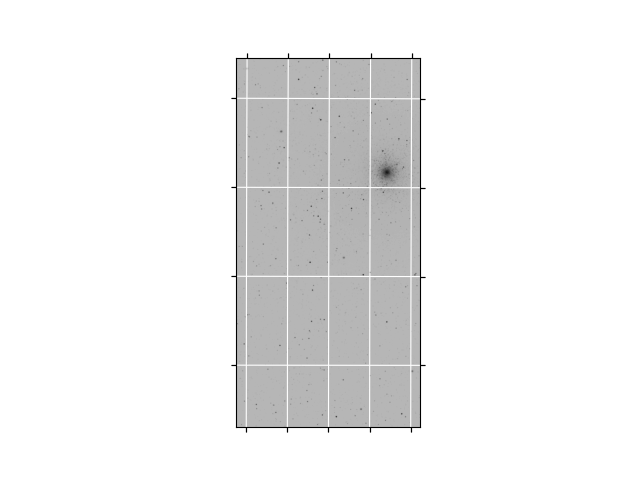

In [8]:
# Display full HDU image specified by target.
(fid,hduidx,ra,dec) = target

# Make sure archive file is valid.  Normally this will always be true, but we 
# are recovering from a "Mass Storage System" outage.
assert client.fitscheck(fid)['valid'], f"Invalid FITS file fid={fid}"

#'https://marsnat1-pat.csdc.noirlab.edu/api/retrieve/09a586a9d93a14a517f6d2e0e25f53da/?hdus=0,37'}
# Only get Primary and HDU containing our target.
fname = client.getimage(fid,hdus=[0,hduidx+1])
header0 = fits.getheader(fname, 0) # hdu0=Primary, hdu1=image
image_data1, header1 = fits.getdata(fname, 1, header=True) # hdu0=Primary, hdu1=image
print(f'HDU size in pixels = {image_data1.shape}')

%matplotlib widget
wcs = WCS(header1)
plt.subplot(projection=wcs)
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.imshow(image_data1, origin='lower', cmap='gray_r', norm='log')
plt.show()

## Documentation for client.cutout

In [9]:
client.cutout?

Signature: client.cutout(ra, dec, size, md5, hduidx, outfile=None, verbose=None)
Docstring:
Generate and get a single cutout (FITS) from the Astro Data Archive.

This is an UNSUPPORTED and EXPERIMENTAL feature.
It may be removed without notice!

Args:
    ra (:obj:`float`): right ascension (decimal degrees) of center of target
.
    dec (:obj:`float`): declination (decimal degrees) of center of target.

    size (:obj:`int`): Width and Height of desired cutout images (in pixels)

    fid (:obj:`str`): File ID of FITS image in Astro Data Archive

    hduidx (:obj:`int`): Index of HDU in FITS file of Astro Data Archive

    outfile (str): Create subimage FITS file at this relative path location.

    public_only (:obj:`bool`, optional): If True (the default),
        do not generate cutouts for any targets that reference
        Proprietary images.
        If False, generate all cutouts but only allow Authorized users
        to retrieve the tarfile.  NOTE: unauthorized users will not be

<a class="anchor" id="cutout_single"></a>
## Cutout and Display a single subimage

Get subimage centered at ra,dec=(283.763875, -30.479861) size 150. From image fid,hduidx=(09a586a9d93a14a517f6d2e0e25f53da, 36)
cutout url=http://localhost:8060/experimental/cutout/09a586a9d93a14a517f6d2e0e25f53da?ra=283.763875&dec=-30.479861&size=150&hduidx=37
curl -H 'Content-Type: application/json' 'http://localhost:8060/experimental/cutout/09a586a9d93a14a517f6d2e0e25f53da?ra=283.763875&dec=-30.479861&size=150&hduidx=37'
subimage as been cutout into local FITS file: subimage_09a586a9d93a14a517f6d2e0e25f53da_283_-30.fits


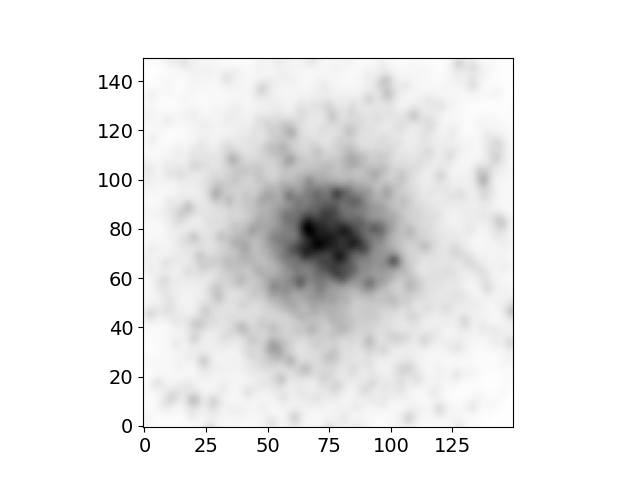

In [10]:
subimage_size = 150
print(f'Get subimage centered at ra,dec={(ra,dec)} size {subimage_size}. From image fid,hduidx=({fid}, {hduidx})')
# get FITS file
subimage = client.cutout(ra, dec, subimage_size, fid, hduidx, verbose=True)
print(f'subimage as been cutout into local FITS file: {subimage}')

image_data = fits.getdata(subimage)
plt.figure()
plt.imshow(image_data, origin='lower', cmap='gray_r')

<a class="anchor" id="cutout_batch"></a>
# Get a BATCH of cutouts

In [11]:
print(f'Using Client context: \n{client.info}')

Using Client context: 
{'astroget_vers': '0.0.4a3.dev1', 'api_vers': 6.0, 'url': 'http://localhost:8060', 'verbose': False, 'show_curl': True, 'connect_timeout': 3.05, 'read_timeout': 300.0}


<a class="anchor" id="discoverBatch"></a>
## Set Targets for several cutouts 
Each Target consists of a tuple containing: 
- ImageId
- HDU
- RA
- DEC

## Documentation for client.cutouts

In [12]:
client.cutouts?

Signature:
client.cutouts(
    size,
    target_list,
    tarfile='cutouts.tar',
    public_only=True,
    background=False,
    verbose=None,
)
Docstring:
Retrieve a batch of cutout images from the Astro Data Archive.

This is an UNSUPPORTED and EXPERIMENTAL feature.
It may be removed without notice!

Args:
    size (:obj:`int`): Width and Height of desired cutout images (in pixels)

    target_list (:obj:`list`): List of 'targets'. Each 'target' consists
        of a tuple containing: fileId, hduIdx, RA_center, DEC_center

    background (:obj:`bool`, optional): If False (the default),
        wait for all subimages to produced, then return a tarfile
        containing all sub-images.
        If True, return a RunId (string) that can be used to poll
        and retrieve the tarfile.
        The tarfile will only be available for 24 hours from the time
        it is generated.

    tarfile (str): Create tarfile at this relative path location.
        The tarfile will contain each cuto

## Get a batch of cutouts and put the files in a named tarfile

In [13]:
client.cutouts(150, targets, tarfile='notebook-cutouts.tar')

curl -H 'Content-Type: application/json' -d '[["09a586a9d93a14a517f6d2e0e25f53da", 37, 283.763875, -30.479861], ["2836105d9c941692f185a7e9ee902eab", 35, 283.763875, -30.479861], ["2d13e23d0cf2762890edaf9a179c3a1d", 37, 283.763875, -30.479861], ["3c8421ce38bf2a9112e3fbbb18405c33", 35, 283.763875, -30.479861], ["523c69cef368eaf24a66ac4010792490", 35, 283.763875, -30.479861], ["a5fb3eef401a24461e4cd4c25e773d8f", 37, 283.763875, -30.479861], ["a5fb3eef401a24461e4cd4c25e773d8f", 44, 283.763875, -30.479861], ["b5cb08bbcf5c03e036b4f08f115e5773", 35, 283.763875, -30.479861], ["bb72cb6b898159456030c268a2b04028", 35, 283.763875, -30.479861], ["bc1db7e4587c3966a2a73b12c33236b8", 35, 283.763875, -30.479861]]' 'http://localhost:8060/experimental/cutouts/?size=150&background=0'


'From RunId=R-0049'

In [14]:
# Look at the contents of the tarfile
! tar --list -f notebook-cutouts.tar

MANIFEST.csv
cutout_0.fits
cutout_1.fits
cutout_2.fits
cutout_3.fits
cutout_4.fits
cutout_5.fits
cutout_7.fits
cutout_8.fits
cutout_9.fits


In [15]:
# Extract the MANIFEST and two cutout (FITS file)
! tar --get -f notebook-cutouts.tar MANIFEST.csv
! tar --get -f notebook-cutouts.tar cutout_1.fits
! tar --get -f notebook-cutouts.tar cutout_3.fits

## Look at the MANIFEST

In [16]:
import pandas as pd
pd.read_csv('MANIFEST.csv')  

,Cutout File,FileId,Hdu,RA,DEC,Archive File,Error
0,cutout_0.fits,09a586a9d93a14a517f6d2e0e25f53da,37.0,283.763875,-30.479861,/archive-data/20210827/ct4m/2021A-0124/m54-1....,False
1,cutout_1.fits,2836105d9c941692f185a7e9ee902eab,35.0,283.763875,-30.479861,/archive-data/20180523/ct4m/2018A-0159/m54-2....,False
2,cutout_2.fits,2d13e23d0cf2762890edaf9a179c3a1d,37.0,283.763875,-30.479861,/archive-data/20210702/ct4m/2021A-0124/m54-3....,False
3,cutout_3.fits,3c8421ce38bf2a9112e3fbbb18405c33,35.0,283.763875,-30.479861,/archive-data/20180428/ct4m/2018A-0159/m54-4....,False
4,cutout_4.fits,523c69cef368eaf24a66ac4010792490,35.0,283.763875,-30.479861,/archive-data/20180428/ct4m/2018A-0159/m54-5....,False
5,cutout_5.fits,a5fb3eef401a24461e4cd4c25e773d8f,37.0,283.763875,-30.479861,/archive-data/20210702/ct4m/2021A-0124/m54-6....,False
6,cutout_7.fits,b5cb08bbcf5c03e036b4f08f115e5773,35.0,283.763875,-30.479861,/archive-data/20180429/ct4m/2018A-0159/m54-7....,False
7,cutout_8.fits,bb72cb6b898159456030c268a2b04028,35.0,283.763875,-30.479861,/archive-data/20180429/ct4m/2018A-0159/m54-8....,False
8,cutout_9.fits,bc1db7e4587c3966a2a73b12c33236b8,35.0,283.763875,-30.479861,/archive-data/20180429/ct4m/2018A-0159/m54-9....,False
9,run_id = 49,NaN,NaN,NaN,NaN,NaN,NaN


## Look at a couple of cutouts

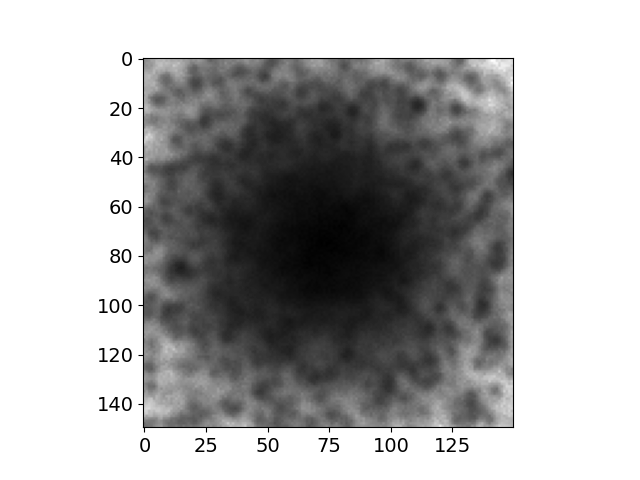

In [17]:
image_data = fits.getdata('cutout_1.fits', ext=0)
plt.figure()
plt.imshow(image_data, cmap='gray')

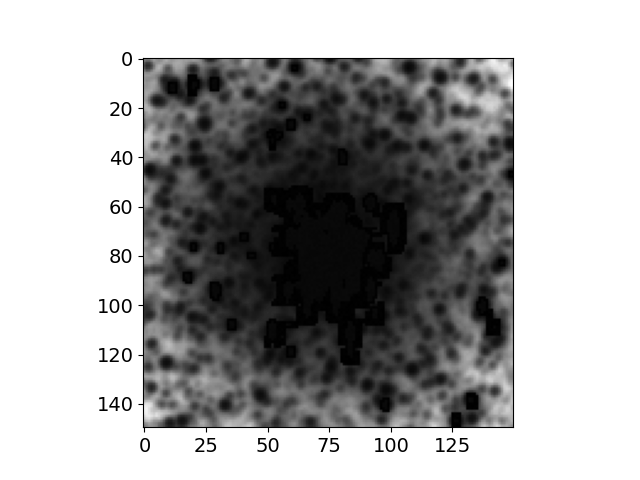

In [18]:
image_data = fits.getdata('cutout_3.fits', ext=0)
plt.figure()
plt.imshow(image_data, cmap='gray')

# All Done

In [19]:
import datetime
print(f'Finished: {datetime.datetime.now()}')

Finished: 2023-10-27 04:49:56.940019


cutout_0.fits  cutout_2.fits  cutout_4.fits  cutout_7.fits  cutout_9.fits
cutout_1.fits  cutout_3.fits  cutout_5.fits  cutout_8.fits


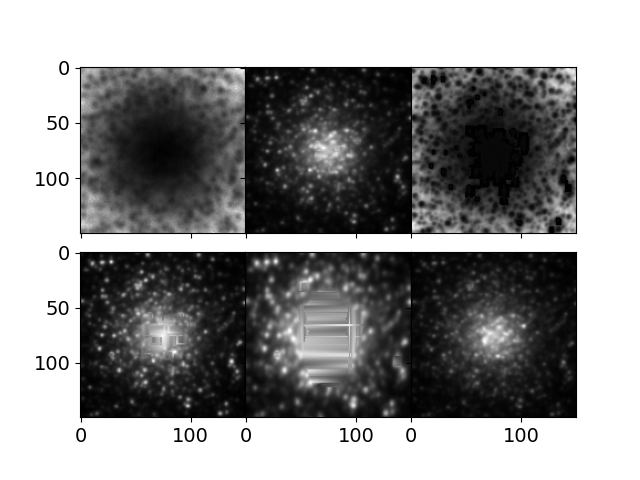

In [20]:
! tar --extract -f notebook-cutouts.tar 
! ls cutout_*.fits
fig = plt.figure()
gs = fig.add_gridspec(2, 3, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')

axs[0, 0].imshow(fits.getdata('cutout_1.fits', ext=0), cmap='gray')
axs[0, 1].imshow(fits.getdata('cutout_2.fits', ext=0), cmap='gray')
axs[0, 2].imshow(fits.getdata('cutout_3.fits', ext=0), cmap='gray')

axs[1, 0].imshow(fits.getdata('cutout_8.fits', ext=0), cmap='gray')
axs[1, 1].imshow(fits.getdata('cutout_5.fits', ext=0), cmap='gray')
axs[1, 2].imshow(fits.getdata('cutout_7.fits', ext=0), cmap='gray')

for ax in fig.get_axes():
    ax.label_outer()